# Rossmann销售预测

**Rossmann** 是欧洲的一家连锁药店。在欧洲7个国家经营着3000多家药店。目前，Rossmann门店经理的任务是提前六 周预测他们的日常销量。商店的销售受到许多因素的影响，包括促销、竞争、学校和国家假日、季节性和所在地区。成千上万的门店经理根据其独特偏好进行销售预测，造成结果的准确性可能会偏差很大。

   可靠的销售预测使商店经理能够制定有效的员工时间表，提高生产力和积极性。通过帮助 Rossmann 创建一个健壮的预测模型，将会帮助商店经理专注于他们最重要的事情:他们的客户和他们的团队。

**数据文件：**

 - train.csv -每家店销售数据集，用于训练
 - store.csv -每家店信息数据集
 - test.csv  -跟"train.csv"结构⼀样，缺少需要提交的"Sales"字段，用于最终的测试
 - sample_submission.csv -提交数据集的参考样本
   



### 可视化图表

In [4]:
# coding: utf-8
 
#开发环境：windows10, Anacoda3.5 , jupyter notebook ,python3.6 
#库： numpy,pandas,matplotlib,seaborn,xgboost,time,warnings
#运行时间：CPU: i5-6700HQ，约0.5h
 
#项目名称： Rossmann 销售预测

#导入所需要的库
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from time import time
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 准备数据

所需数据都存放于当前目录的/dataset/中

部分字段解释：
1. Id:测试集内(商店、日期)的组合。
2. Store:表示每个商店的唯一Id。
3. Sales:任意一天的销售额，也是我们要预测的字段。
4. Open:是否开门，0=关门，1=开门。
5. StateHoliday:国家假日，一般假日国家假期都会关门，所有学校在公共假日都会关门，a=公共假日，b=东部假日，c=圣诞节，0=不是假日。
6. StoreType:商店类型，有四种，abcd。
7. Assortment:分类级别，a=基础，b=额外，c=扩展。
8. CompetitionDistance:竞争对手距离。
9. CompetitionOpenSince\[Month/Year\]:给出最近竞争对手的开张时间。
10. Promo:表示商店当天是否进行促销？
11. Promo2:表示商店是否进行持续的促销活动，0=没有参数，1=参与。
12. Promo2Since\[Year/Week\]:商店开始持续促销的年/星期。
13. PromoInterval:持续促销活动开始的间隔，"Feb,May,Aug,Nov"表示给定商店某一年的2589月开始持续促销活动。

### 加载数据

In [5]:
train = pd.read_csv('./dataset/train.csv',parse_dates=[2])
test  = pd.read_csv('./dataset/test.csv',parse_dates=[3])
store = pd.read_csv('./dataset/store.csv')

### 读取数据

In [6]:
#查看训练集
train.head(5).append(train.tail())


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


总共数据 1017209 条数据，数据完整，无null字段

In [8]:
#查看测试集
test.head(5).append(test.tail())

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0
41087,41088,1115,6,2015-08-01,1.0,0,0,1


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


"Open" 字段有11个缺失值显示为：NaN。

In [10]:
#查看店铺数据
store.head(5).append(store.tail())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [11]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


总共有 1115 条数据，对应分布于德国的1115间商店；其中CompetitionOpenSinceMonth、CompetitionOpenSinceYear只有 761 条数据，也就是有 354 个商店缺失对应的竞争对手的开张日期相关信息；promo2促销相关的字段Promo2SinceWeek、Promo2SinceYear、PromoInterval只有 571 条；竞争对手的距离字段CompetitionDistance显示缺失值为 3 条 。

#### 时间跨度

In [12]:
print(min(train['Date']),max(train['Date']))

2013-01-01 00:00:00 2015-07-31 00:00:00


**数据集的数据从2013-01-01 到 2015-17-31 时间跨度2.5年左右**

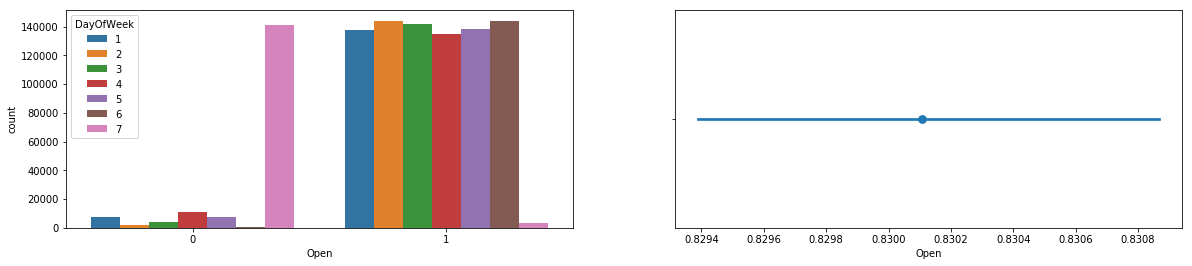

In [13]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(20,4))
sns.countplot(x='Open',hue='DayOfWeek', data=train, ax=axis1)
sns.pointplot(x='Open',hue='DayOfWeek', data=train, ax=axis2)

**可以看出主要是dayofweek = 7 星期天休息**

In [14]:
train['Year'] = train['Date'].apply(lambda x:int(str(x)[:4]))
train['Month'] = train['Date'].apply(lambda x:int(str(x)[5:7]))
train['Date'] = train['Date'].apply(lambda x: (str(x)[:7]))
test['Year']  = test['Date'].apply(lambda x: int(str(x)[:4]))
test['Month'] = test['Date'].apply(lambda x: int(str(x)[5:7]))
test['Date']  = test['Date'].apply(lambda x: (str(x)[:7]))
avgsales    = train.groupby('Date')["Sales"].mean()
percentchngsales = train.groupby('Date')["Sales"].sum().pct_change()



In [15]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
0,1,5,2015-07,5263,555,1,1,0,1,2015,7
1,2,5,2015-07,6064,625,1,1,0,1,2015,7
2,3,5,2015-07,8314,821,1,1,0,1,2015,7
3,4,5,2015-07,13995,1498,1,1,0,1,2015,7
4,5,5,2015-07,4822,559,1,1,0,1,2015,7


** 销售额变化情况 **

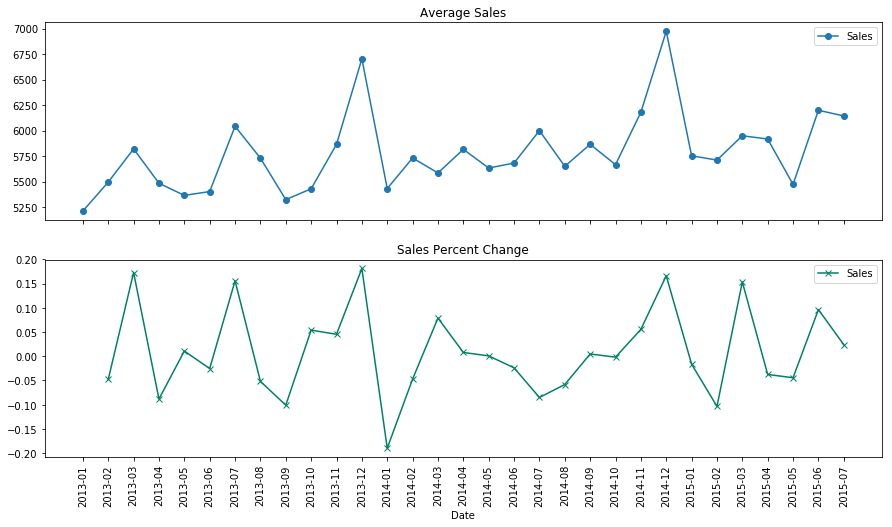

In [16]:
average_sales = train.groupby('Date')['Sales'].mean()
pct_change_sales = train.groupby('Date')['Sales'].sum().pct_change()
fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

ax1 = average_sales.plot(legend=True,ax=axis1,marker='o',title="Average Sales")
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist(), rotation=90)

pct_change_sales.plot(legend=True,ax=axis2,marker='x',rot=90,colormap="summer",title="Sales Percent Change")
plt.show()

** 消费客户情况 **

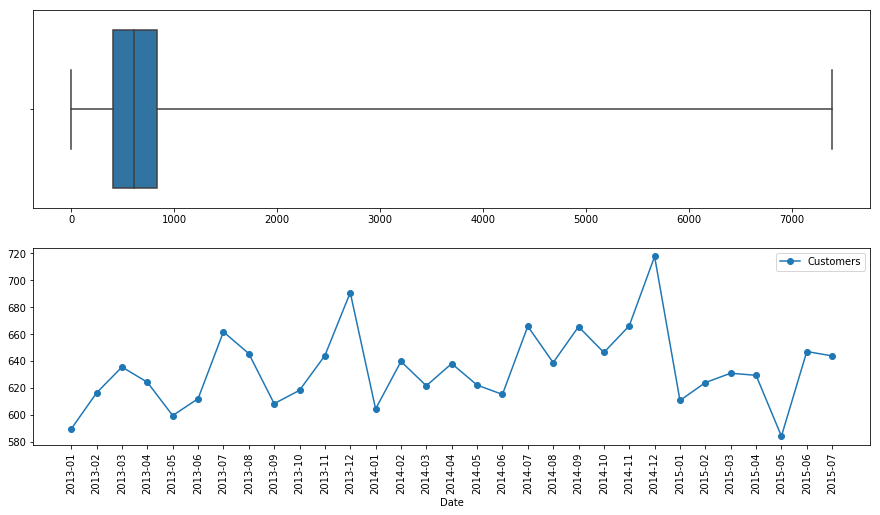

In [17]:
fig, (axis1,axis2) = plt.subplots(2,1,figsize=(15,8))

# Plot max, min values, & 2nd, 3rd quartile
sns.boxplot([train["Customers"]], whis=np.inf, ax=axis1)

# group by date and get average customers, and precent change
average_customers      = train.groupby('Date')["Customers"].mean()
# pct_change_customers = rossmann_df.groupby('Date')["Customers"].sum().pct_change()

# Plot average customers over the time
# it should be correlated with the average sales over time
ax = average_customers.plot(legend=True,marker='o', ax=axis2)
ax.set_xticks(range(len(average_customers)))
xlabels = ax.set_xticklabels(average_customers.index.tolist(), rotation=90)

** 一周消费/客量情况 **

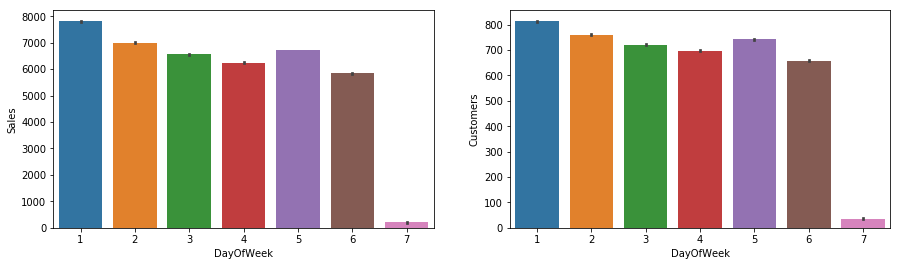

In [18]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='DayOfWeek', y='Sales', data=train, order=[1,2,3,4,5,6,7], ax=axis1)
sns.barplot(x='DayOfWeek', y='Customers', data=train, order=[1,2,3,4,5,6,7], ax=axis2)

** 根据是否有促销查看销售情况 **

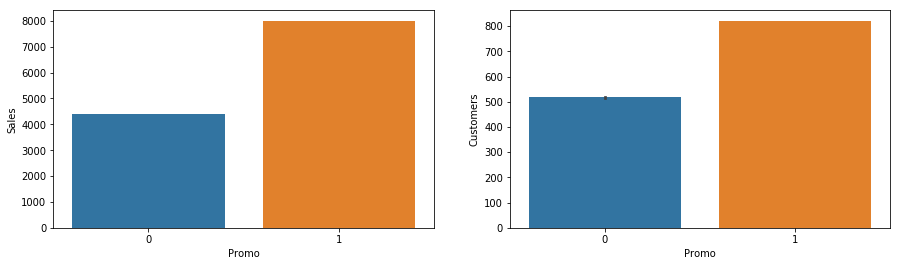

In [19]:
fig,(axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x= 'Promo',y = 'Sales',data= train,ax = axis1)
sns.barplot(x= 'Promo',y = 'Customers',data = train,ax = axis2)
plt.show()

** 节假日销售情况 **

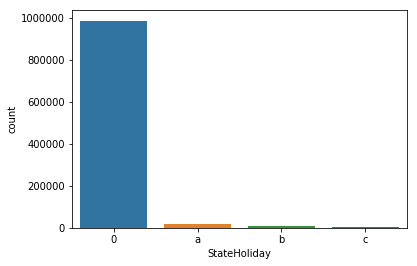

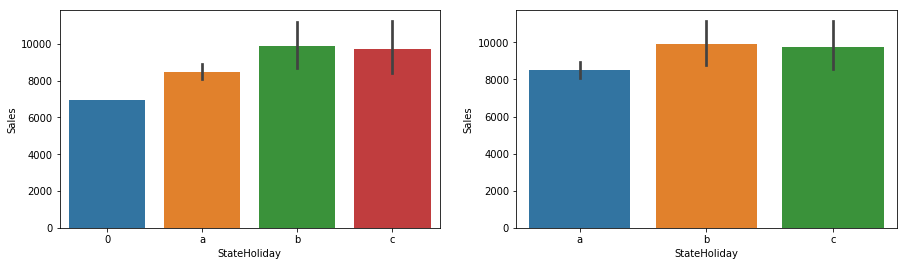

In [20]:
train['StateHoliday'].loc[train['StateHoliday']==0] ='0'
sns.countplot(x='StateHoliday',data = train)
fig,(axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x='StateHoliday',y='Sales',data = train[train["Sales"] > 0],ax=axis1)
mask = (train["StateHoliday"] != "0") & (train["Sales"] > 0)
sns.barplot(x='StateHoliday', y='Sales', data=train[mask], ax=axis2)
# sns.barplot(x='StateHoliday',y='Sales',data=sales[(sales['StateHoliday']!=0) & sales['Sales']>0],ax = axis2)
plt.show()

** 节假日和非节假日销售量对比 **

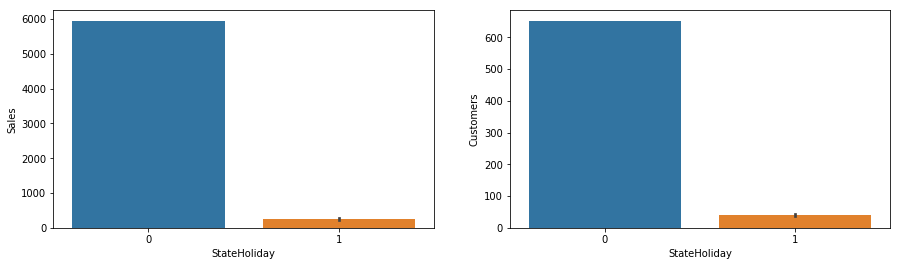

In [21]:
train['StateHoliday'] = train['StateHoliday'].map({0:0,"0":0,"a":1,"b":1,"c":1})

fig,(axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x='StateHoliday',y='Sales',data=train,ax=axis1)
sns.barplot(x='StateHoliday',y='Customers',data= train,ax=axis2)
plt.show()

** 数值特征跟销售量的相关性 **

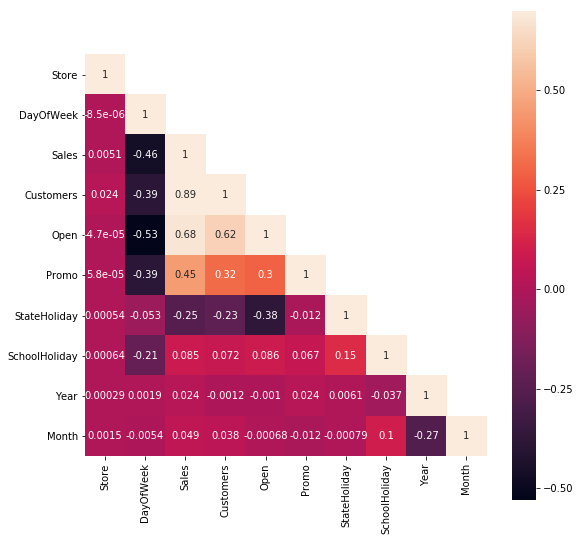

In [22]:
correlation_map = train[train.columns].corr()
obj = np.array(correlation_map)
obj[np.tril_indices_from(obj)] = False
fig,ax= plt.subplots()
fig.set_size_inches(9,9)
sns.heatmap(correlation_map, mask=obj,vmax=.7, square=True,annot=True)

In [23]:
def plotter(StringA , StringB):
  fig, axes = plt.subplots(2,1)
  fig.set_size_inches(15, 10)
  sns.barplot(x=StringA, y=StringB, data=train ,hue="DayOfWeek", ax = axes[0])
  sns.boxplot(x=StringA, y=StringB, data=train ,hue="DayOfWeek", ax=axes[1])

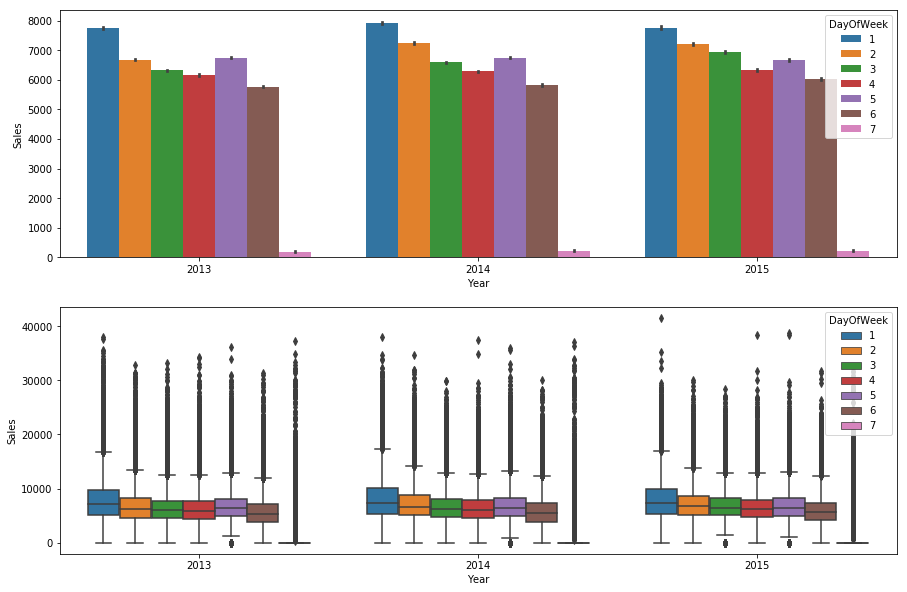

In [24]:
plotter("Year" , "Sales")

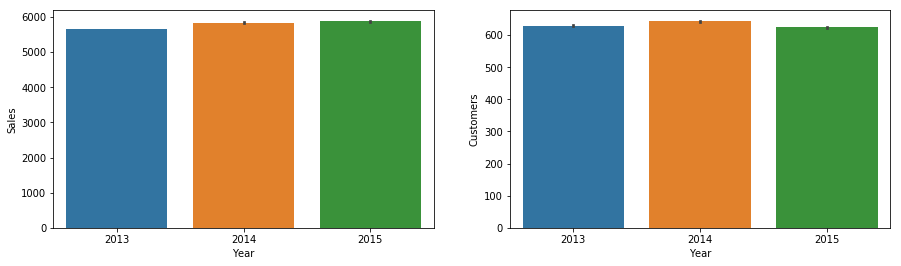

In [25]:
#比较年份的销售和每年到访的用户数量

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Year', y='Sales', data=train, ax=axis1)
sns.barplot(x='Year', y='Customers', data=train, ax=axis2)

In [26]:

test["StateHoliday"] = test["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})

In [27]:
train.StateHoliday.value_counts()

0    986159
1     31050
Name: StateHoliday, dtype: int64

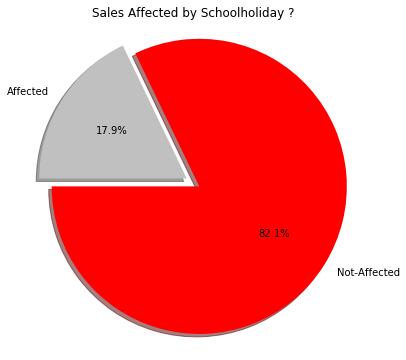

In [28]:
labels = 'Not-Affected' , 'Affected'
sizes = train.SchoolHoliday.value_counts()
colors = ['red', 'silver']
explode = (0.1, 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Sales Affected by Schoolholiday ?")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()

In [29]:
train.SchoolHoliday.value_counts()

0    835488
1    181721
Name: SchoolHoliday, dtype: int64

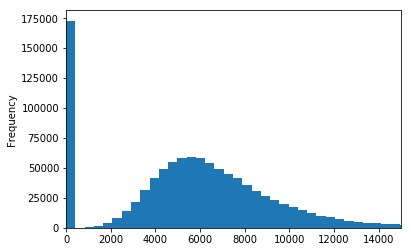

In [30]:
train["Sales"].plot(kind='hist',bins=100,xlim=(0,15000))

### 消费者数量箱型图和直方图分析

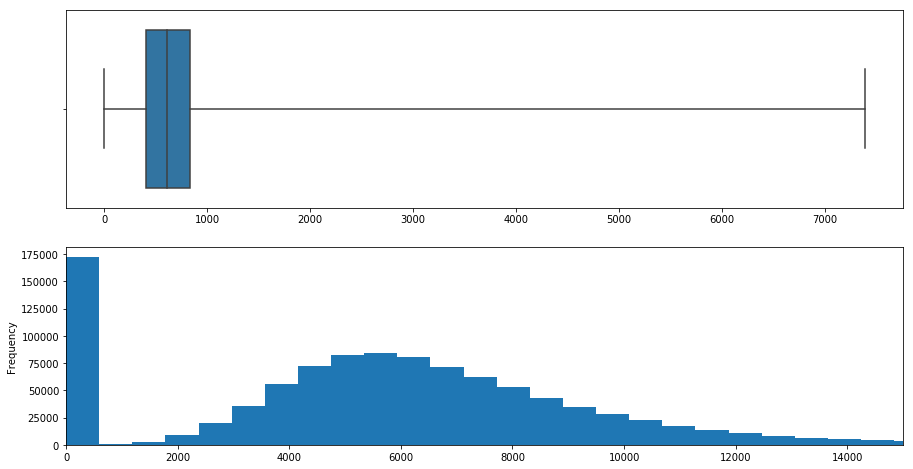

In [31]:
fig,(axis1,axis2) = plt.subplots(2,1,figsize=(15,8))
sns.boxplot([train['Customers']],whis=np.inf,ax=axis1)
train['Sales'].plot(kind='hist',bins=70,xlim=(0,15000),ax=axis2)
plt.show()

### 销售额箱型图和直方图分析

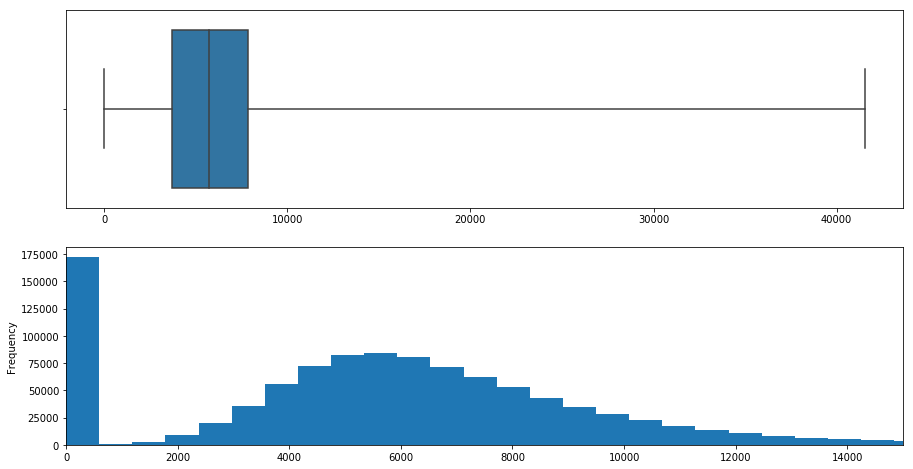

In [32]:
fig,(axis1,axis2) = plt.subplots(2,1,figsize=(15,8))
sns.boxplot([train['Sales']],whis=np.inf,ax=axis1)
train['Sales'].plot(kind='hist',bins=70,xlim=(0,15000),ax=axis2)
plt.show()

In [33]:
average_sales_customer = train.groupby('Store')[['Sales','Customers']].mean()
sales_customers_df = pd.DataFrame({'Store':average_sales_customer.index,
                                'Sales':average_sales_customer['Sales'],
                                'Customers':average_sales_customer['Customers']},
                               columns=['Store','Sales','Customers'])
store_df = pd.merge(sales_customers_df,store,on='Store')
store_df.head()

,Store,Sales,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3945.704883,467.646497,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4122.991507,486.045648,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5741.253715,620.286624,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,8021.769639,1100.057325,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,3867.110403,444.360934,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### 竞争者距离分析

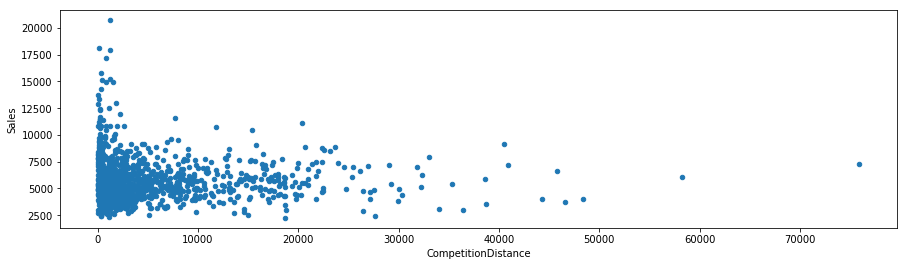

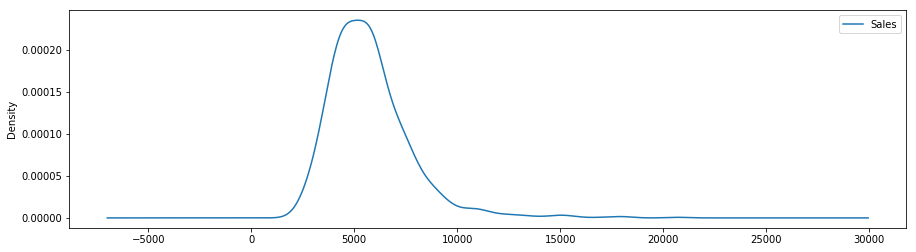

In [34]:
store_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].median())
store_df.plot(kind='scatter',x='CompetitionDistance',y='Sales',figsize=(15,4))
store_df.plot(kind='kde',x='CompetitionDistance',y='Sales',figsize=(15,4))

** 不同商家类型的销售情况 **

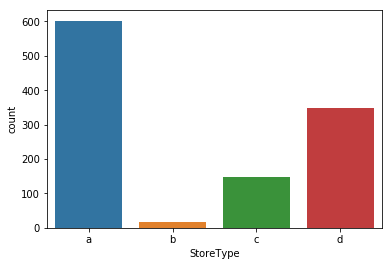

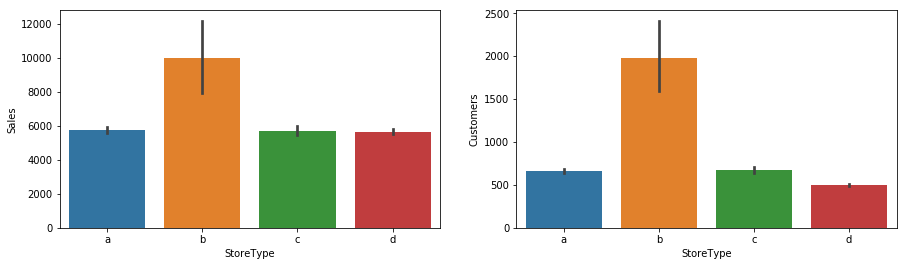

In [35]:
sns.countplot(x='StoreType', data=store_df, order=['a','b','c', 'd'])

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='StoreType', y='Sales', data=store_df, order=['a','b','c', 'd'],ax=axis1)
sns.barplot(x='StoreType', y='Customers', data=store_df, order=['a','b','c', 'd'], ax=axis2)

** 不同商店级别的销售情况 **

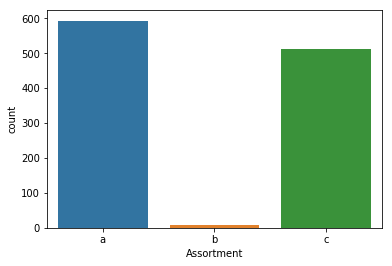

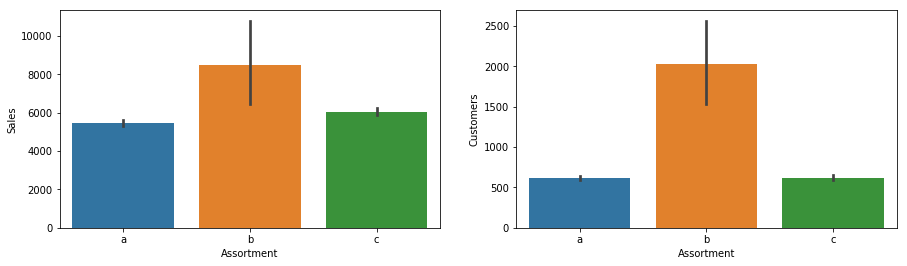

In [36]:
sns.countplot(x='Assortment',data=store_df,order=['a','b','c'])
fig,(axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x='Assortment',y='Sales',data=store_df,order=['a','b','c'],ax=axis1)
sns.barplot(x='Assortment',y='Customers',data=store_df,order=['a','b','c'],ax=axis2)
plt.show()

In [41]:
#合并store信息到train和test数据集中
train_store_sales_df = pd.merge(train, store, on='Store')

#### 销量跟竞争者距离关系

Text(0.5,1,'Sales & CompetitionDistance')

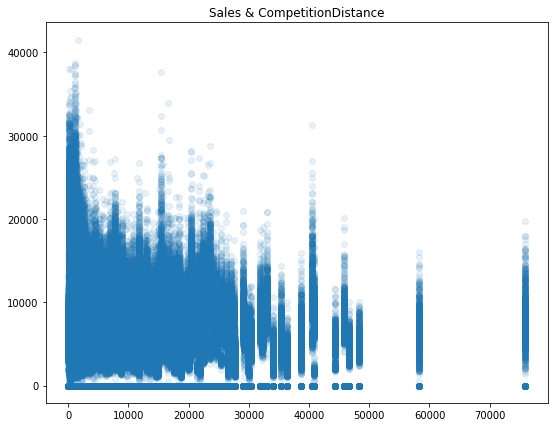

In [42]:
plt.figure(figsize=(9,7))
plt.scatter(data=train_store_sales_df, x='CompetitionDistance', y='Sales', alpha=0.1)
plt.title("Sales & CompetitionDistance")

In [47]:
#### 销量跟是否持续促销

In [45]:
train_store_sales_df.groupby('Promo2').Sales.sum()

Promo2
0    3111542628
1    2761637995
Name: Sales, dtype: int64

Text(0.5,1,'Sales & Promo2')

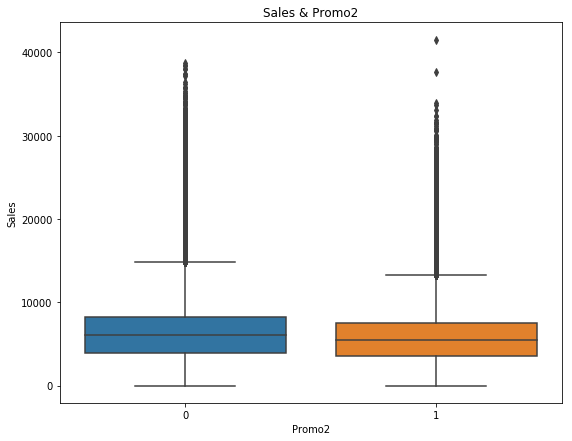

In [46]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='Promo2', y='Sales')
plt.title("Sales & Promo2")

In [49]:
#### 销量跟促销月份

Text(0.5,1,'Sales & PromoInterval')

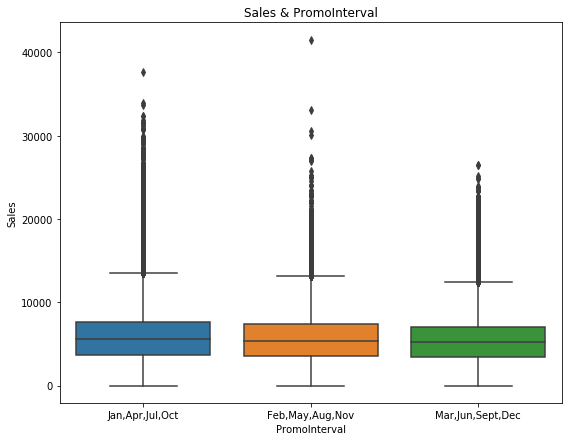

In [50]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='PromoInterval', y='Sales')
plt.title("Sales & PromoInterval")

根据以上的图表分析，销售与客户之间存在很强的正相关关系。ales跟这些有很存在很大的相关性Date, DayofWeek, WeekofYear, CompetitionOpen, PromoOpen.

#### Sales & DayOfWeek & StoreType & Promo 

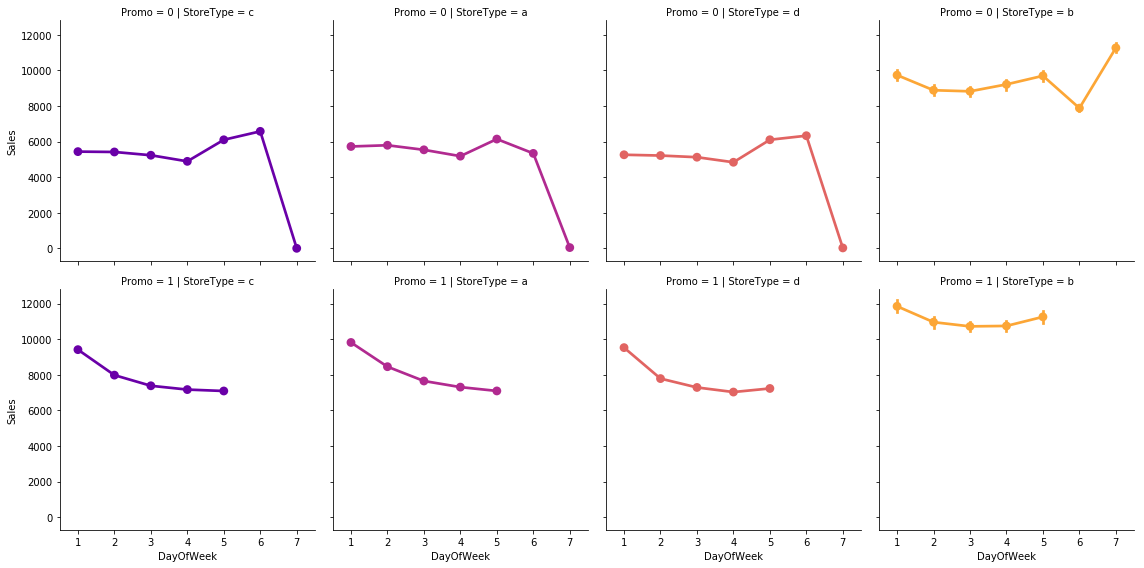

In [52]:
sns.factorplot(data = train_store_sales_df, x = 'DayOfWeek', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

#### Sales & Month & StoreType & Promo 

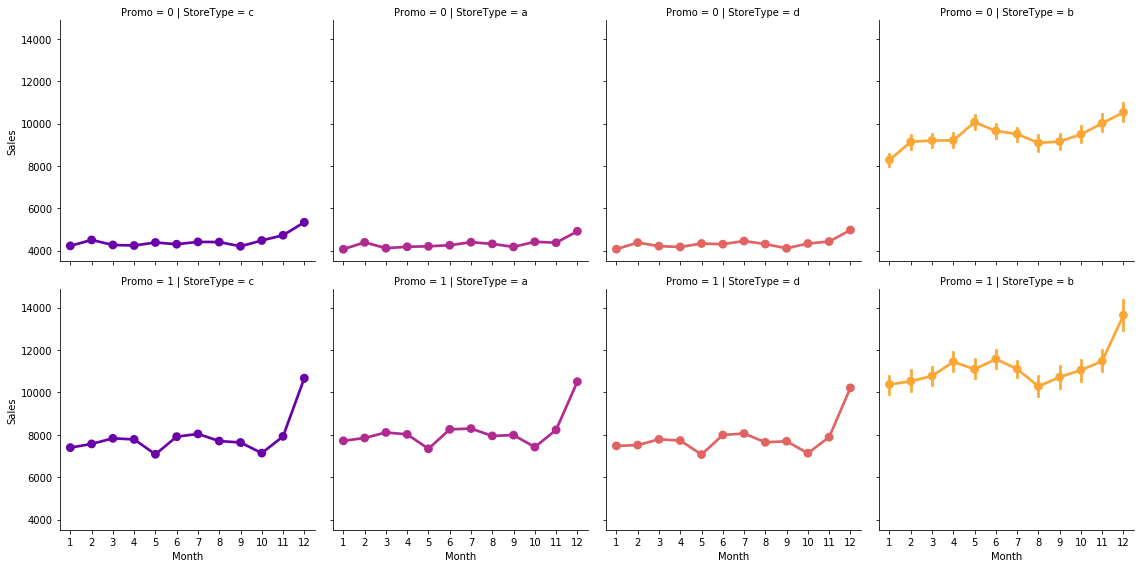

In [54]:
sns.factorplot(data = train_store_sales_df, x = 'Month', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

#### Sales & Month & Assortment	 & StoreType

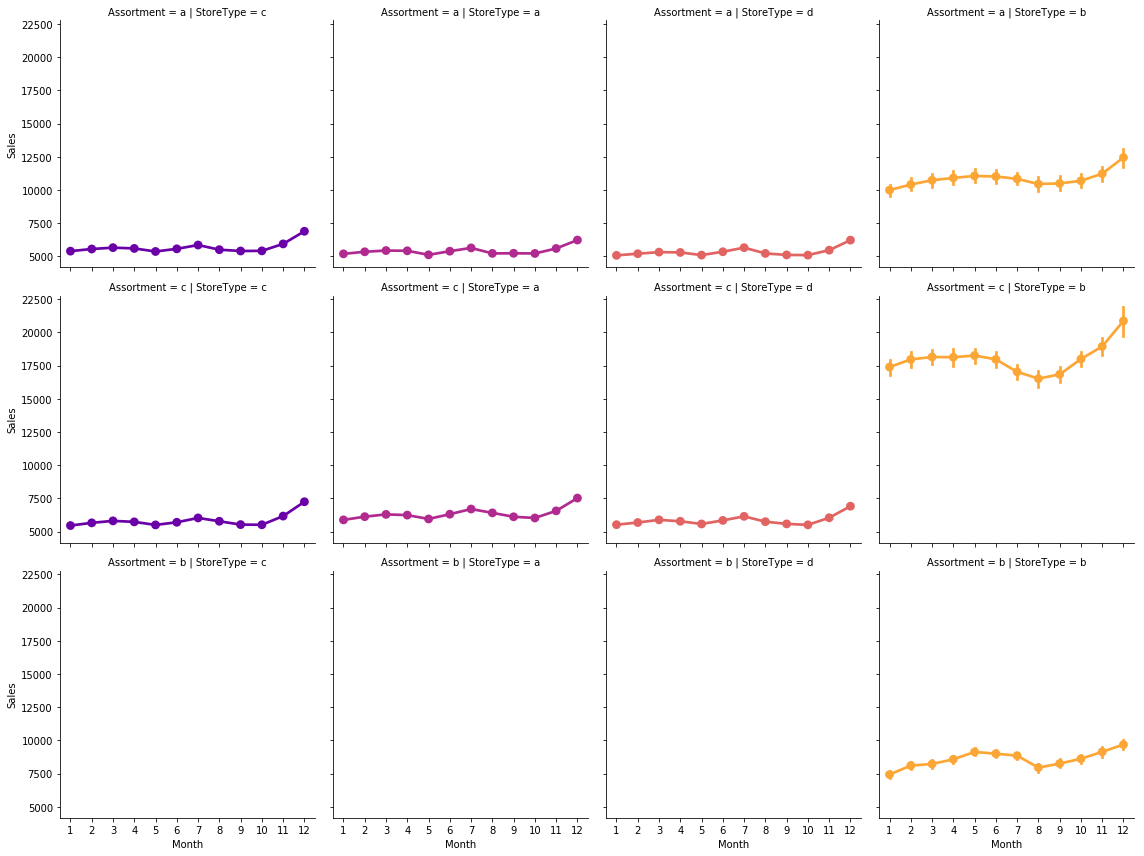

In [55]:
sns.factorplot(data = train_store_sales_df, x = 'Month', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Assortment')